In [13]:
import os
import re
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

def extract_averages_from_log(logfile_name):
    # Regular expressions for extracting energy and throughput values
    energy_pattern = re.compile(r"Total energy used: ([\d.]+) Joules")
    throughput_pattern = re.compile(r"mean Network throughput: ([\d.]+) \[Mb/s\]")
    
    # Lists to hold extracted values for averaging
    energy_values = []
    throughput_values = []

    with open(logfile_name, 'r') as file:
        content = file.read()
        
        # Split the content into blocks
        blocks = content.split("From Main : Total")
        
        # Process each block
        for block in blocks:
            if "400 chunks will be downloaded" in block:
                # Extract energy value
                energy_match = energy_pattern.search(block)
                if energy_match:
                    energy_values.append(float(energy_match.group(1)))
                
                # Extract throughput value
                throughput_match = throughput_pattern.search(block)
                if throughput_match:
                    throughput_values.append(float(throughput_match.group(1)))

    # Calculate averages
    avg_energy = sum(energy_values) / len(energy_values) if energy_values else 0
    avg_throughput = sum(throughput_values) / len(throughput_values) if throughput_values else 0
    
    return avg_energy, avg_throughput

# Define the directory path
directory_path = './output_logs_9-21-2023/'

# List all files in the directory
all_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

data=[]
# Define the regular expression pattern
pattern = re.compile(r'P(\d+)_C(\d+)\.log')

for filename in all_files:
    filename_ = os.path.basename(filename)
    avg_energy, avg_throughput = extract_averages_from_log(filename)
    match = pattern.match(filename_)
    if match:
        number1, number2 = map(int, match.groups())
        # Instead of just creating a tuple, populate the data list
        data.append({
            "parallelism": number1,
            "concurrency": number2,
            "throughput": avg_throughput,
            "energy": avg_energy
        })

# Convert the list of dictionaries to a dataframe
df = pd.DataFrame(data)

# If you want to see the dataframe
print(df)

    parallelism  concurrency   throughput        energy
0            16            1  2459.163500   3902.366542
1            16            8  6577.045100   2352.367995
2            16           16  4577.574125   2522.075529
3             2           16  5688.650400   2164.288417
4             4            2  2208.667200   2771.881820
5             8            8  5874.215087   1884.476719
6            16            4  6666.292875   2511.597758
7             4            4  4266.515000   1788.968100
8             4            8  5333.115600   2174.732238
9             2            1   598.022800   7469.339027
10            1           16  4266.501100   1778.666559
11            1            1   303.660900  14377.141906
12            1            2   597.746900   7557.942499
13            1            8  2208.667900   2741.340529
14            2            4  2251.749100   2657.011295
15           16            2  4586.545600   2860.268734
16            4           16  7110.732900   2268

In [14]:
df = df.sort_values(by=['concurrency', 'parallelism'])
df.to_csv('log_summary_C_P_1-16.csv', index=False)
print(df)

    parallelism  concurrency   throughput        energy
11            1            1   303.660900  14377.141906
9             2            1   598.022800   7469.339027
21            4            1  1160.182700   4237.313113
23            8            1  2322.864900   2590.214500
0            16            1  2459.163500   3902.366542
12            1            2   597.746900   7557.942499
19            2            2  1173.386400   4131.792163
4             4            2  2208.667200   2771.881820
22            8            2  4266.495200   1793.478581
15           16            2  4586.545600   2860.268734
20            1            4  1166.422100   4307.985743
14            2            4  2251.749100   2657.011295
7             4            4  4266.515000   1788.968100
17            8            4  4728.720400   2795.614981
6            16            4  6666.292875   2511.597758
13            1            8  2208.667900   2741.340529
24            2            8  4187.477222   1773

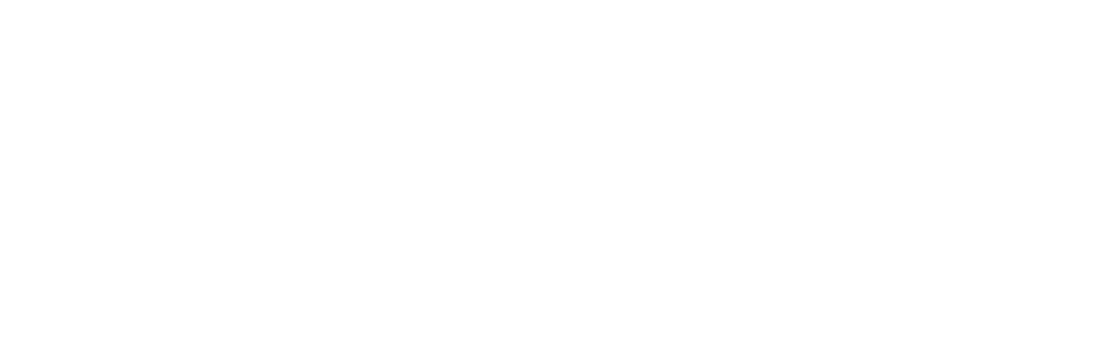

In [15]:
fig_energy = go.Figure(data=[go.Scatter3d(
    x=df['concurrency'],
    y=df['parallelism'],
    z=df['energy'],
    mode='markers',
    marker=dict(size=8, color=df['energy'], colorscale='Viridis', opacity=0.8)
)])

fig_energy.update_layout(scene=dict(
                    xaxis_title='Concurrency',
                    yaxis_title='Parallelism',
                    zaxis_title='Energy (Joules)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
                  )
pyo.iplot(fig_energy)


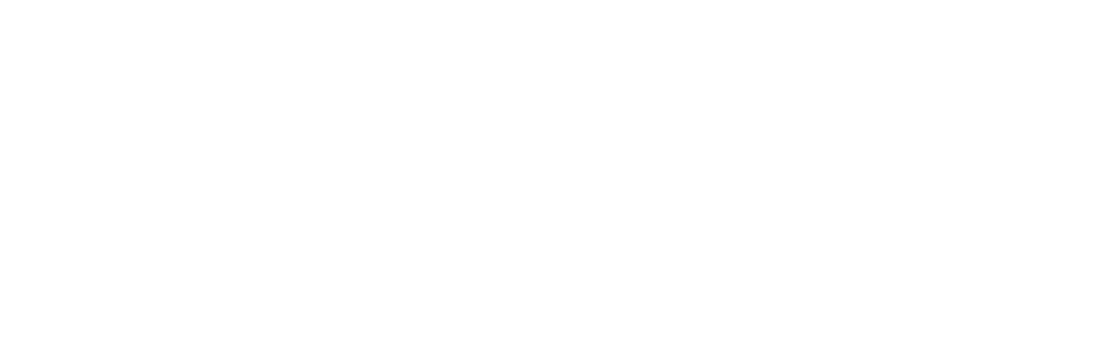

In [16]:
# 3D Plot for Throughput
fig_throughput = go.Figure(data=[go.Scatter3d(
    x=df['concurrency'],
    y=df['parallelism'],
    z=df['throughput'],
    mode='markers',
    marker=dict(size=8, color=df['throughput'], colorscale='Viridis', opacity=0.8)
)])

fig_throughput.update_layout(scene=dict(
                    xaxis_title='Concurrency',
                    yaxis_title='Parallelism',
                    zaxis_title='Throughput (mbps)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10)
                  )
fig_throughput.show()

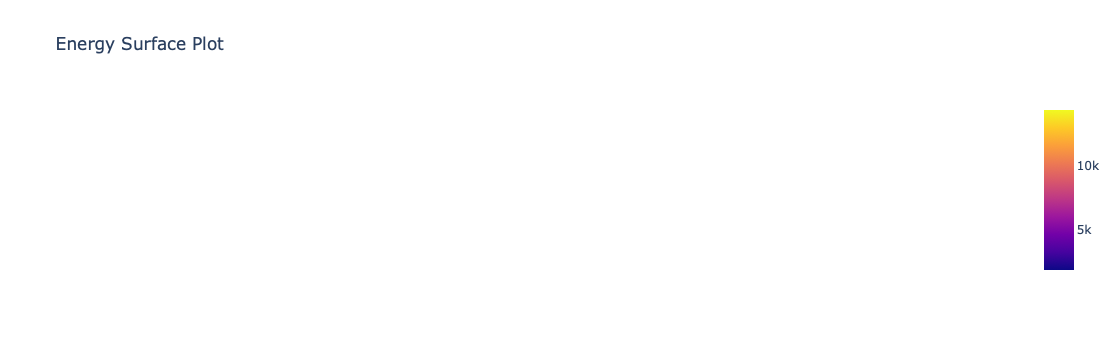

In [17]:
pivot_table_energy = df.pivot_table(index='parallelism', columns='concurrency', values='energy')
pivot_table_throughput = df.pivot_table(index='parallelism', columns='concurrency', values='throughput')

# Plotting energy
fig_energy = go.Figure(data=[go.Surface(z=pivot_table_energy.values, x=pivot_table_energy.columns, y=pivot_table_energy.index)])
fig_energy.update_layout(title='Energy Surface Plot', scene=dict(xaxis_title='Concurrency', yaxis_title='Parallelism', zaxis_title='Energy (Joules)',zaxis=dict(range=[-100, df['energy'].max()])))
import plotly.io as pio
# pio.write_html(fig_energy, 'fig_energy.html')
fig_energy.show()

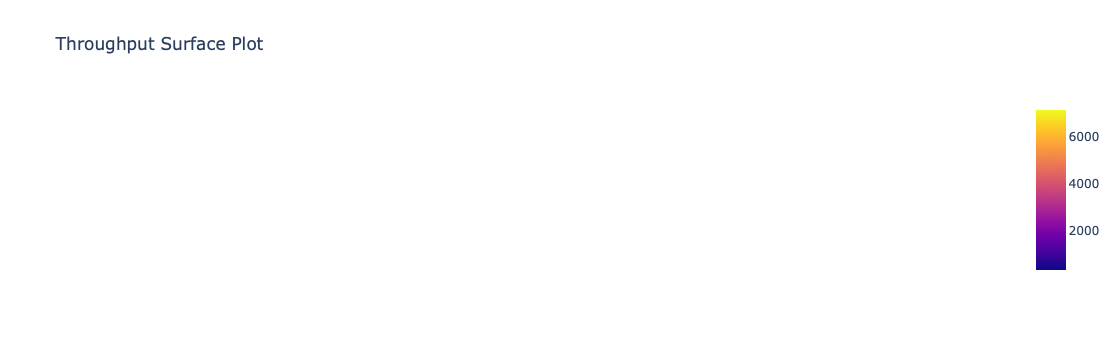

In [18]:
# Plotting throughput
fig_throughput = go.Figure(data=[go.Surface(z=pivot_table_throughput.values, x=pivot_table_throughput.columns, y=pivot_table_throughput.index)])
fig_throughput.update_layout(title='Throughput Surface Plot', scene=dict(xaxis_title='Concurrency', yaxis_title='Parallelism', zaxis_title='Throughput (Mbps)'))
# pio.write_html(fig_throughput, 'fig_throughput.html')
fig_throughput.show()

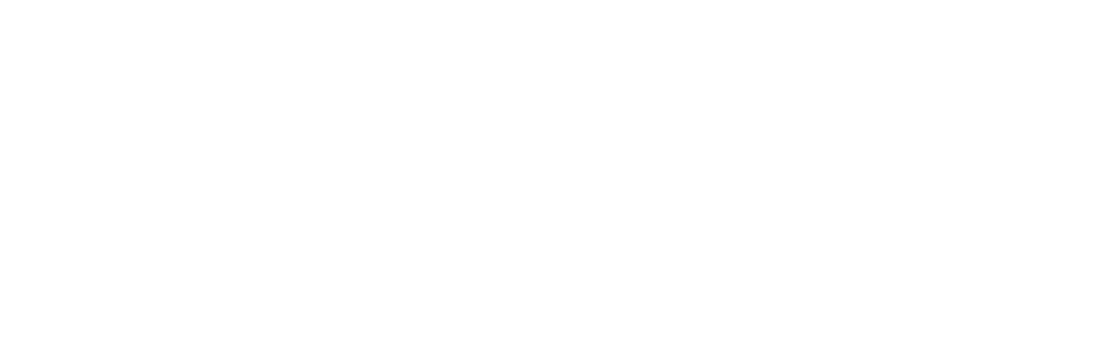

In [29]:
import pandas as pd
import plotly.graph_objects as go

# Assuming 'df' is your DataFrame

fig = go.Figure()

x, y, z = df['concurrency'], df['parallelism'], df['throughput']

fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,
        colorscale='Viridis',
        opacity=0.8
    )
))

fig.update_layout(
    scene=dict(
        xaxis_title='Concurrency',
        yaxis_title='Parallelism',
        zaxis_title='Throughput'
    ),
    margin=dict(r=20, b=10, l=10, t=10)
)

fig.show()


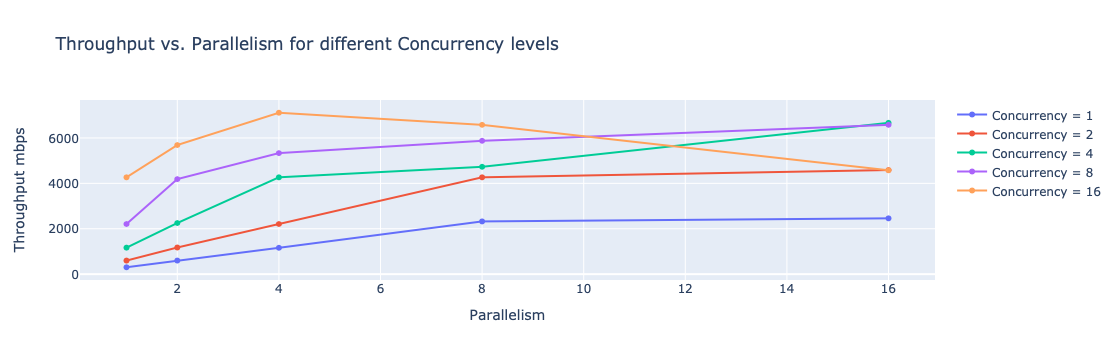

In [19]:
# Plotting
fig = go.Figure()

# Loop through unique concurrency values and plot
for conc in df['concurrency'].unique():
    subset = df[df['concurrency'] == conc]
    fig.add_trace(go.Scatter(x=subset['parallelism'], 
                             y=subset['throughput'], 
                             mode='lines+markers', 
                             name=f'Concurrency = {conc}'))

fig.update_layout(title='Throughput vs. Parallelism for different Concurrency levels',
                  xaxis_title='Parallelism',
                  yaxis_title='Throughput mbps')
fig.show()

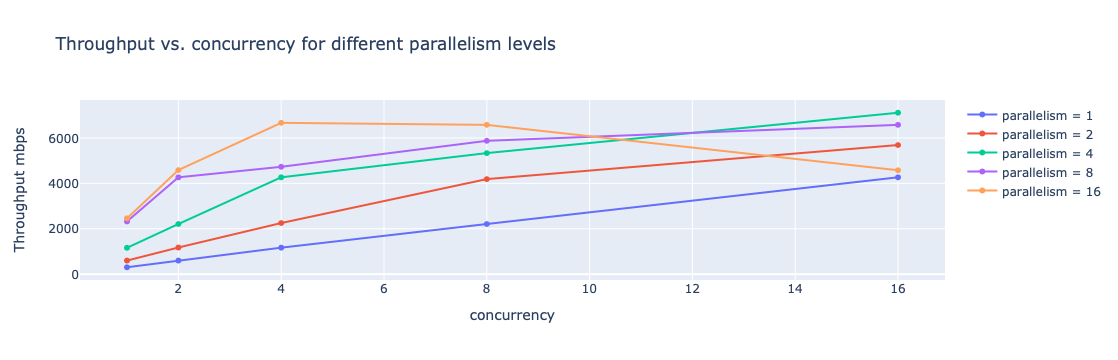

In [20]:
# Plotting
fig = go.Figure()

# Loop through unique concurrency values and plot
for conc in df['parallelism'].unique():
    subset = df[df['parallelism'] == conc]
    fig.add_trace(go.Scatter(x=subset['concurrency'], 
                             y=subset['throughput'], 
                             mode='lines+markers', 
                             name=f'parallelism = {conc}'))

fig.update_layout(title='Throughput vs. concurrency for different parallelism levels',
                  xaxis_title='concurrency',
                  yaxis_title='Throughput mbps')
fig.show()

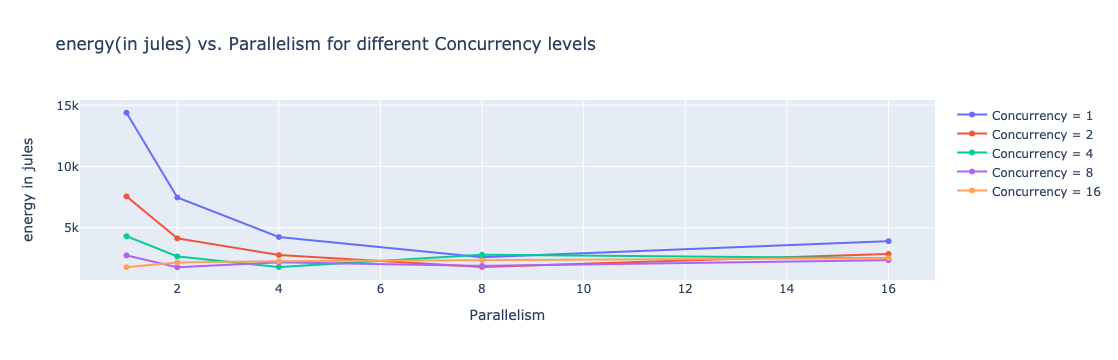

In [21]:
# Plotting
fig = go.Figure()

# Loop through unique concurrency values and plot
for conc in df['concurrency'].unique():
    subset = df[df['concurrency'] == conc]
    fig.add_trace(go.Scatter(x=subset['parallelism'], 
                             y=subset['energy'], 
                             mode='lines+markers', 
                             name=f'Concurrency = {conc}'))

fig.update_layout(title='energy(in jules) vs. Parallelism for different Concurrency levels',
                  xaxis_title='Parallelism',
                  yaxis_title='energy in jules')
fig.show()

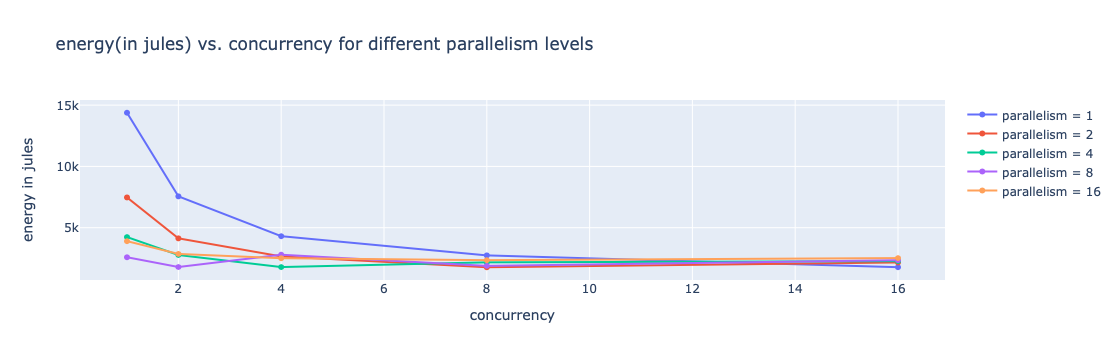

In [22]:
# Plotting
fig = go.Figure()

# Loop through unique concurrency values and plot
for conc in df['parallelism'].unique():
    subset = df[df['parallelism'] == conc]
    fig.add_trace(go.Scatter(x=subset['concurrency'], 
                             y=subset['energy'], 
                             mode='lines+markers', 
                             name=f'parallelism = {conc}'))

fig.update_layout(title='energy(in jules) vs. concurrency for different parallelism levels',
                  xaxis_title='concurrency',
                  yaxis_title='energy in jules')
fig.show()

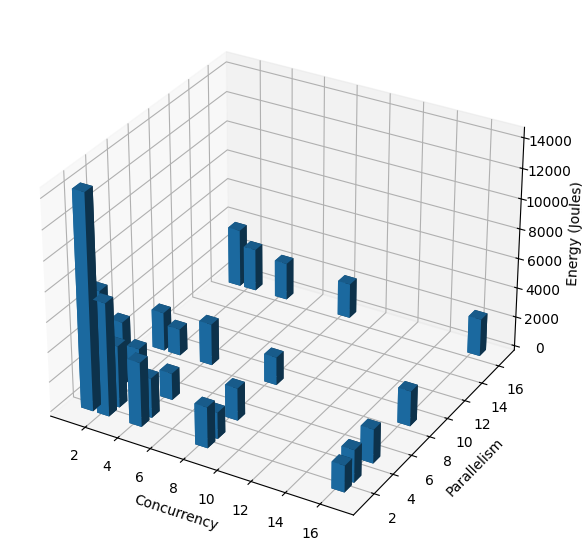

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Your data is assumed to be in the df DataFrame

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract unique values of concurrency and parallelism
unique_concurrency = df['concurrency'].unique()
unique_parallelism = df['parallelism'].unique()

xpos, ypos = np.meshgrid(unique_concurrency, unique_parallelism, indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = 0.75 * np.ones_like(zpos)
dy = dx.copy()
dz = [df[(df['concurrency'] == x) & (df['parallelism'] == y)]['energy'].values[0] for x, y in zip(xpos, ypos)]

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
ax.set_xlabel('Concurrency')
ax.set_ylabel('Parallelism')
ax.set_zlabel('Energy (Joules)')

plt.show()

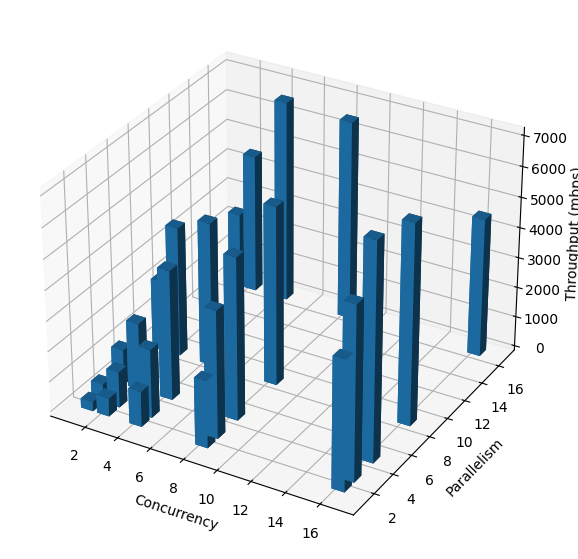

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Your data is assumed to be in the df DataFrame

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract unique values of concurrency and parallelism
unique_concurrency = df['concurrency'].unique()
unique_parallelism = df['parallelism'].unique()

xpos, ypos = np.meshgrid(unique_concurrency, unique_parallelism, indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = 0.75 * np.ones_like(zpos)
dy = dx.copy()
dz = [df[(df['concurrency'] == x) & (df['parallelism'] == y)]['throughput'].values[0] for x, y in zip(xpos, ypos)]

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)
ax.set_xlabel('Concurrency')
ax.set_ylabel('Parallelism')
ax.set_zlabel('Throughput (mbps)')

plt.show()